In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support


In [3]:
import sys
# to print the exact path to the Python executable, notebook is using.
print(sys.executable)

/usr/bin/python3


In [4]:
df = pd.read_csv("/content/drive/MyDrive/Sentiment_Analysis/K8 Reviews.csv")


In [5]:
#Preparing the data
# Droping any rows with missing reviews and rename columns to what Hugging Face expects
df = df[['review', 'sentiment']].dropna()
df.rename(columns={'review': 'text', 'sentiment': 'label'}, inplace=True)
# Converting the pandas DataFrame to a Hugging Face Dataset object
hg_dataset = Dataset.from_pandas(df)

In [6]:
print(hg_dataset)

Dataset({
    features: ['text', 'label'],
    num_rows: 14675
})


In [7]:
#Tokenization of the data
# We'll use DistilBERT
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [8]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_dataset = hg_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/14675 [00:00<?, ? examples/s]

In [9]:
#Spliting the data into training and testing sets
train_test_split = tokenized_dataset.train_test_split(test_size=0.2, seed=42)
print(train_test_split)

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 11740
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2935
    })
})


In [15]:
#Loading the pre-trained model
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
import accelerate
print(f"Accelerate version: {accelerate.__version__}")

Accelerate version: 1.10.1


In [12]:
# Initialization of all the required parameters
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    report_to="none",
)


In [13]:
#creating the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_test_split["train"],
    eval_dataset=train_test_split["test"],
)


In [14]:
# Training.
print("--- Starting Model Training ---")
trainer.train()
print("--- Model Training Complete ---")

--- Starting Model Training ---


Step,Training Loss
10,0.699900
20,0.679000
30,0.687800
40,0.676600
50,0.664600
60,0.649600
70,0.647500
80,0.602900
90,0.594200
100,0.519500


--- Model Training Complete ---



--- Starting Model Evaluation ---


Evaluation Results: {'eval_loss': 0.34192073345184326, 'eval_runtime': 41.5692, 'eval_samples_per_second': 70.605, 'eval_steps_per_second': 8.829, 'epoch': 3.0}

--- Transformer Model Performance ---
Accuracy: 0.8927
Precision: 0.8855
Recall: 0.8809
F1-Score: 0.8832
------------------------------------


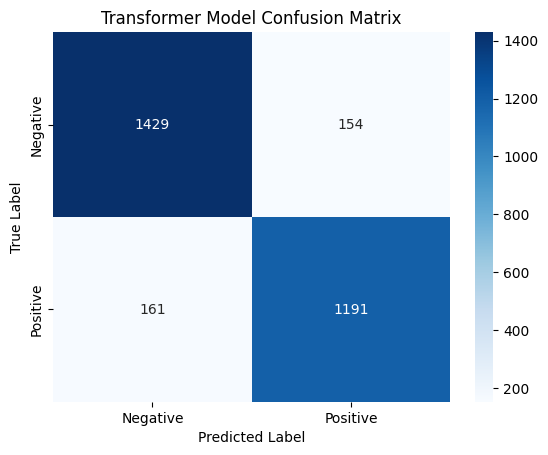

In [16]:
# Model Evaluation
print("\n--- Starting Model Evaluation ---")
evaluation_results = trainer.evaluate()
print("Evaluation Results:", evaluation_results)


# Predicting on the test dataset
predictions_output = trainer.predict(train_test_split["test"])
y_preds = np.argmax(predictions_output.predictions, axis=-1)
y_true = train_test_split["test"]["label"]


# Calculation of performance metrics
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_preds, average='binary')
acc = accuracy_score(y_true, y_preds)

print("--- Transformer Model Performance ---")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print("------------------------------------")

# Ploting a Confusion Matrix
cm = confusion_matrix(y_true, y_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Transformer Model Confusion Matrix')
plt.show()

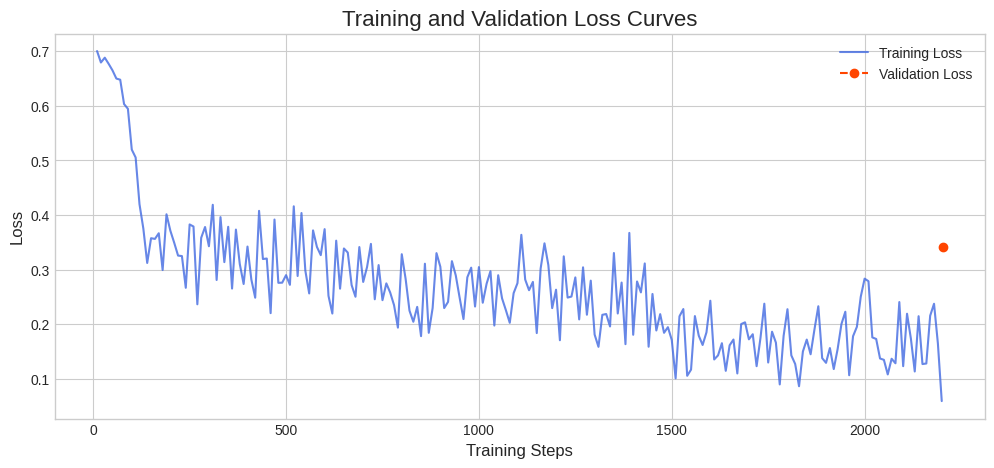

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# The trainer.state.log_history contains all the training and evaluation metrics.
log_history = trainer.state.log_history

# Separate training and evaluation logs
training_logs = [log for log in log_history if 'loss' in log]
evaluation_logs = [log for log in log_history if 'eval_loss' in log]

# Create DataFrames for easier plotting
train_df = pd.DataFrame(training_logs)
eval_df = pd.DataFrame(evaluation_logs)

# --- Plot 1: Training and Validation Loss ---
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(12, 5))

# Plot training loss
plt.plot(train_df['step'], train_df['loss'], label='Training Loss', color='royalblue', alpha=0.8)

# Plot validation loss
plt.plot(eval_df['step'], eval_df['eval_loss'], label='Validation Loss', color='orangered', marker='o', linestyle='--')

plt.title('Training and Validation Loss Curves', fontsize=16)
plt.xlabel('Training Steps', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.show()

